In [1]:
import os 
import gc
import re
import random
from typing import List

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

from utils import read_json

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["TOKENIZERS_PARALLELISM"] = "false"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

/home/florincuconasu/miniconda3/envs/pon/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda', index=0)

In [2]:
def seed_everything(seed=10):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
SEED=10
seed_everything(SEED)

In [3]:
@torch.no_grad()
def get_answer_attention_to_documents(
    generated_string: str, 
    tokenizer: AutoTokenizer, 
    model: AutoModelForCausalLM, 
    device: str = 'cuda',
) -> List[np.ndarray]:
    output_tokenized = tokenizer(
        generated_string, 
        padding=True, 
        truncation=True, 
        return_tensors="pt"
    ).to(device)

    # Get the attention scores from the model
    outputs = model(
        **output_tokenized,   
        output_attentions=True,
    )

    def find_documents_positions(generated_string):
        # Matching only documents in the context (up until string 'Question:')
        pattern = r"Document \[\d+\].*?(?=Document|Question:)" 
        matches = re.finditer(pattern, generated_string, re.DOTALL)
        
        documents_positions = [(match.start(), match.end()) for match in matches]
        return [(output_tokenized.char_to_token(i), output_tokenized.char_to_token(j)) for i, j in documents_positions]

    def find_answer_positions(generated_string):
        # Get answer up until the newline '\n'
        pattern = r"^\s*Answer:\s*(.*)$"
        matches = re.finditer(pattern, generated_string, re.MULTILINE)

        answer_positions = [(match.start() + len("Answer:"), min(match.end(), len(generated_string)-1)) for match in matches]
        assert len(answer_positions) == 1, "More than one answer found"
        answer_positions = answer_positions[0]
        return output_tokenized.char_to_token(answer_positions[0]), output_tokenized.char_to_token(answer_positions[1])
    
    documents_token_positions = find_documents_positions(generated_string)
    answer_token_positions = find_answer_positions(generated_string)

    
    answer_attention_to_documents = []
    for hidden_layer in outputs.attentions:
        # [batch_size, num_attention_heads, seq_len, seq_len]
        attention_np = hidden_layer.float()
        # Average over the attention heads: [batch_size, seq_len, seq_len]
        attention_np = attention_np.mean(1)
        # Squeeze the first position since it is assumed batch_size == 1
        # [seq_len, seq_len]
        attention_np = attention_np.squeeze(0).detach().cpu().numpy()
        
        # Select answers tokens only: [ans_len, seq_len]
        answer_attention = attention_np[answer_token_positions[0]:answer_token_positions[1]]
        # Average answers tokens: [seq_len]
        answer_attention = answer_attention.mean(0)
        # 'answer_attention' contains the attention scores from the answer 
        # to all other tokens in the sequence

        # For each document average the attentions from the answer to the document
        doc_avgs = np.array([answer_attention[i:j].mean() for i, j in documents_token_positions])
        normalized_doc_avgs = doc_avgs / doc_avgs.sum()
        answer_attention_to_documents.append(normalized_doc_avgs)


    del outputs
    gc.collect()
    torch.cuda.empty_cache()

    # [num_layers, num_documents]
    return answer_attention_to_documents

In [4]:
def plot_attentions(
    answer_attention_to_documents: List[np.ndarray], 
    gold_position: int = None, 
    title: str = None, 
    save: bool = False, 
    saving_name: str = None
) -> None:
    # Plotting
    plt.figure(figsize=(10,8))

    num_docs = len(answer_attention_to_documents[0])
    assert gold_position < num_docs, f"Gold position {gold_position} is out of range"

    ticks = [f'Doc_{i}' for i in range(num_docs)]
    if gold_position is not None:
        ticks[gold_position] = 'GOLD'

    sns.heatmap(answer_attention_to_documents, annot=False, cmap='Blues', xticklabels=ticks)

    # Setting the "GOLD" tick label color
    gold_color = (212/255, 175/255, 55/255)  # RGB color normalized to [0, 1]
    ax = plt.gca()  # Get the current axis
    for label in ax.get_xticklabels():
        if label.get_text() == 'GOLD':
            label.set_color(gold_color)
            label.set_fontweight('bold')
            
    plt.xticks(rotation=20)
    plt.yticks(rotation=0)
    plt.xlabel("Documents in Context")
    plt.ylabel("Attention Layers")
    title = f"{title}" if title else "Attention Heatmap"
    plt.title(title)

    plt.tight_layout()
    if save:
        os.makedirs("figures", exist_ok=True)
        if saving_name:
            plt.savefig(f"figures/{saving_name}.png", dpi=600)
        else:
            plt.savefig(f"figures/{title}.png", dpi=600)
    else:
        plt.show()

In [6]:
from llm import LLM

llm_id = "meta-llama/Llama-2-7b-chat-hf"
model_max_length=4096
llm = LLM(
    llm_id, device, quantization_bits=4, 
    model_max_length=model_max_length
)
tokenizer = llm.tokenizer

Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.79s/it]


In [ ]:
numdoc13_gold_at12_distracting = read_json('../data/gen_res/Llama-2-7b-chat-hf/train/classic/contriever/13_doc/numdoc13_gold_at12_answerless_info_all_extended.json')

In [ ]:
numdoc13_gold_at12_random = read_json('../data/gen_res/Llama-2-7b-chat-hf/train/classic/contriever/13_doc/numdoc13_gold_at12_rand_answerless_info_all_extended.json')

In [10]:
idx = 3865
generated_string_distracting = numdoc13_gold_at12_distracting[idx]['prompt'] + " " + numdoc13_gold_at12_distracting[idx]['generated_answer']
print("CORRECT ANS", numdoc13_gold_at12_distracting[idx]['answers'])
print()
print(generated_string_distracting)

CORRECT ANS ['Lando Calrissian']

You are given a question and you MUST respond by EXTRACTING the answer (max 5 tokens) from one of the provided documents. If none of the documents contain the answer, respond with NO-RES.
Documents:
Document [13629136](Title: Millennium Falcon) make it out of Kessel in less than 20 parsecs. After integrating the memory module of Lando's damaged L3 droid into the ship's navigation, Solo is able to take a "shortcut" dangerously close to the black holes. Chewbacca indicates the real distance was closer to 13 parsecs, but Han insisted, "Not if you round down." implying that the distance of "less than twelve parsecs" was embellished by Solo. The "Falcon" has been depicted many times in the franchise, and ownership has changed several times. Joss Whedon credits the "Millennium Falcon" as one of his two primary inspirations for his "Firefly"
Document [6533118](Title: The Han Solo Trilogy) refuses to believe Han was not involved in the swindle, and punches his

In [11]:
generated_string_random = numdoc13_gold_at12_random[idx]['prompt'] + " " + numdoc13_gold_at12_random[idx]['generated_answer']
print("CORRECT ANS", numdoc13_gold_at12_random[idx]['answers'])
print()
print(generated_string_random)

CORRECT ANS ['Lando Calrissian']

You are given a question and you MUST respond by EXTRACTING the answer (max 5 tokens) from one of the provided documents. If none of the documents contain the answer, respond with NO-RES.
Documents:
Document [2914497](Title: Ethnobotany) in traditional Iroquois cultures is rooted in a strong and ancient cosmological belief system. Their work provides perceptions and conceptions of illness and imbalances which can manifest in physical forms from benign maladies to serious diseases. It also includes a large compilation of Herrick’s field work from numerous Iroquois authorities of over 450 names, uses, and preparations of plants for various ailments. Traditional Iroquois practitioners had (and have) a sophisticated perspective on the plant world that contrast strikingly with that of modern medical science. Researcher Cassandra Quave at Emory University has used ethnobotany to address the problems that arise from
Document [3506350](Title: RAF Cranwell) Cen

In [12]:
answer_attention_to_documents_distracting = get_answer_attention_to_documents(generated_string_distracting, tokenizer, llm.model, device)

LlamaModel is using LlamaSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [13]:
answer_attention_to_documents_random = get_answer_attention_to_documents(generated_string_random, tokenizer, llm.model, device)

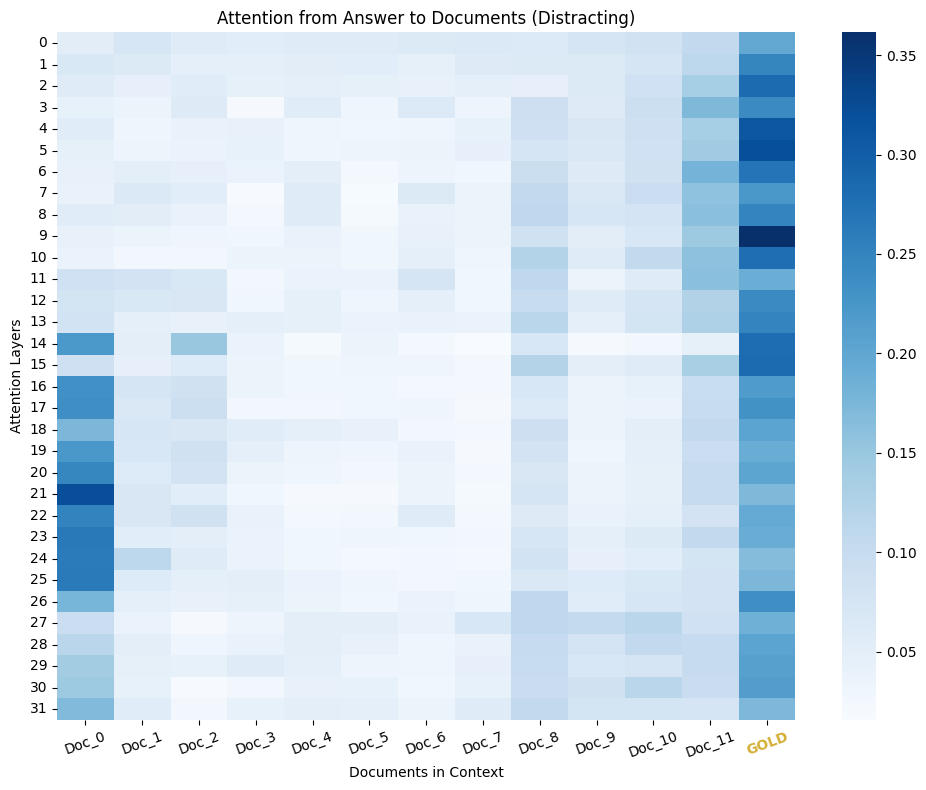

In [14]:
plot_attentions(answer_attention_to_documents_distracting, 12, title="Attention from Answer to Documents (Distracting)", save=False)

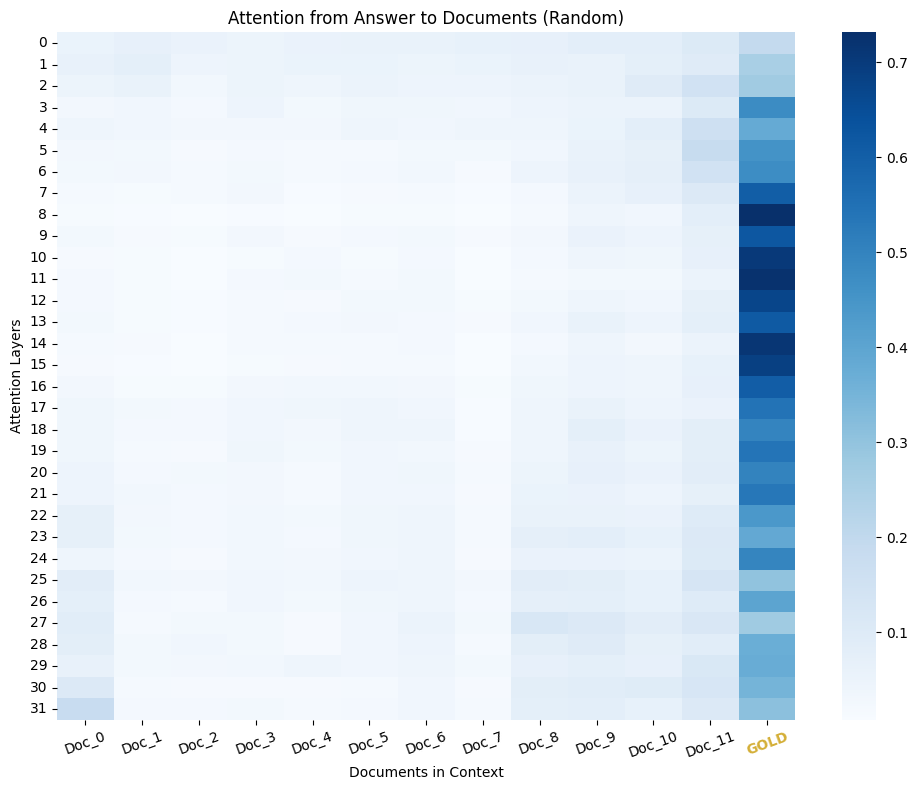

In [15]:
plot_attentions(answer_attention_to_documents_random, 12, title="Attention from Answer to Documents (Random)", save=False)